In [238]:
import pandas as pd
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import scipy

import re

#Data handling
from sklearn.model_selection import train_test_split


import seaborn


import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

In [117]:
def generate_IEMOCAP_df():
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    for line in openFile.readlines():
                        if(line.startswith('[')):
                            line = line.split()
                            key = line[3]
                            emotion = line[4]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        for conversation in conversations:
            files_path = temp_conversations_path+conversation
            files = os.listdir(files_path)
            for file in files:
                key,suf = file.split('.')
                if(suf == 'wav'):
                    data[key].append(files_path + '/'+ file)
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    return full

In [176]:
# full = generate_IEMOCAP_df()
data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
data =data.reset_index()

In [177]:
#full.to_csv('data/IEMOCAP_sentences.csv')

#data = data[(data.emotion != 'oth')&(data.emotion != 'xxx')]
data.groupby('emotion').count()

,index,start_time,end_time,text,wav_path,valence,arousal,dominance
emotion,,,,,,,,
ang,1103,1103,1103,1103,1103,1103,1103,1103
dis,2,2,2,2,2,2,2,2
exc,1041,1041,1041,1041,1041,1041,1041,1041
fea,40,40,40,40,40,40,40,40
fru,1849,1849,1849,1849,1849,1849,1849,1849
hap,595,595,595,595,595,595,595,595
neu,1708,1708,1708,1708,1708,1708,1708,1708
oth,3,3,3,3,3,3,3,3
sad,1084,1084,1084,1084,1084,1084,1084,1084


In [178]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data['emotion'] = data['emotion'].map( emotional_mapping ).astype(int)

In [179]:
#Exclude ['oth', 'xxx', 'dis', 'sur','fea']
data = data[data.emotion < 6]
y = data.emotion
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(5904, 9) (5904,)
(1476, 9) (1476,)


In [123]:
#test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav'
def get_mfcc_feature(filename,n_mfcc):
    y, sr = librosa.load(filename)
    #IPython.display.Audio(data=y,rate=sr)
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)
    print("Finished "+ filename)
    return np.mean(mfcc.T,axis=0)

def map_for_emotion(y_list, emotional_mapping,emotion):
    return list(map(lambda x: 1 if x == emotional_mapping[emotion] else 0,y_list))

In [181]:
x_train = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M035.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M018.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F014.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M028.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M040.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M007.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M032.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F048.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F00

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M036.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M034.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M071.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M004.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M067.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F007.wav
Fi

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_F026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M060.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M073.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_M056.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F012.wav
Fini

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M01

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M039.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_F003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F010.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F061.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_2/Ses02M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F019.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M051.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M027.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M011.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M039.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M011.wav
Finished dat

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M077.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M041.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F002.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M051.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M022.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_F016.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M017.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M002.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M001.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_M000.wav
Finished dat

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_M000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M030.wav
Finished dat

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_F012.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro01/Ses05M_impro01_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_F025.wav
Fi

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F031.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F008.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F022.wav
Finished d

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M02

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F037.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F015.wav
Finished dat

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_F039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F008.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F027.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M042.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F010.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_1/Ses02M_script03_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_sc

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F030.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F032.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M01

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F002.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_M022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M030.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F040.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F078.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_2/Ses05F_script01_2_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M034.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F034.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_sc

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F021.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M017.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F037.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_F026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_M018.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M040.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F032.wav


Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_M038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_M002.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F010.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_2/Ses04M_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M049.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F037.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M044.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_M00

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F029.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_2/Ses01F_script01_2_M001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F001.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F024.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro04/Ses02F_impro04_F008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F007.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_F013.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M046.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M028.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro06/Ses05M_impro06_M007.wav
Finish

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M028.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M029.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F034.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_F007.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F034.wa

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M016.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro02/Ses02M_impro02_M002.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro01/Ses03F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_F010.wav
Fini

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M038.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M032.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F045.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M006.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M008.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_1/Ses01M_script02_1_M040.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M010.wav
Finish

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_2/Ses04M_script02_2_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M013.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F007.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro03/Ses01M_impro03_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_F028.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M042.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M037.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M032.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F074.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_2/Ses05M_script01_2_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_M006.wav


Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_2/Ses03M_script01_2_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_M039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_2/Ses04F_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script02_1_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro04/Ses01M_impro04_F023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_3/Ses05M_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M03

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_3/Ses04M_script01_3_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M041.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_M02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_F021.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro05/Ses05M_impro05_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F018.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F014.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro03/Ses01F_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F036.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_M018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F025.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M000.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro01/Ses04F_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F019.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_F016.wav
Fini

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_2/Ses05F_script02_2_M000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F032.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F031.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M012.wav
Finished data/IEMOCAP_

In [180]:
x_test = list(map(lambda x: get_mfcc_feature(x,20),X_test['wav_path']))

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F034.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_F005.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F005.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro08/Ses03F_impro08_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro04/Ses04M_impro04_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro06/Ses02M_impro06_F015.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M016.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M005.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M031.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F018.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_1/Ses02F_script03_1_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_F021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_F025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro03/Ses05M_impro03_M030.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F038.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M039.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M016.wav
Finished dat

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M006.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M032.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_M008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro04/Ses05M_impro04_M008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M00

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_2/Ses02F_script01_2_F012.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_F022.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M010.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M033.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F030.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F016.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M03

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_M009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_F013.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro01/Ses01M_impro01_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_M020.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_F013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script02_1/Ses04M_script02_1_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro06/Ses03F_impro06_F013.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_F013.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_M021.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M035.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F001.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_M045.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro08/Ses02M_impro08_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_1/Ses04F_script03_1_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M063.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_F016.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro05/Ses02M_impro05_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M016.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro02/Ses04F_impro02_M010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_F012.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro08/Ses02F_impro08_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_F033.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M002.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F006.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_1/Ses03F_script01_1_F047.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M040.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M038.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F043.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M024.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05a/Ses03M_impro05a_M003.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_1/Ses05F_script03_1_M017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1/Ses05M_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_M007.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M066.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M037.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M009.

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M025.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_F021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro01/Ses05F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F065.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_M004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_2/Ses03F_script01_2_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_3/Ses04F_script01_3_M025.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script02_1/Ses04F_script02_1_M023.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M014.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script03_2/Ses05F_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro06/Ses01M_impro06_M007.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_F002.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_3/Ses02M_script01

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_F020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro05/Ses03F_impro05_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M012.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_M013.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro02/Ses02F_impro02_F008.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro03/Ses02F_impro03_M024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_1/Ses01F_script03_1_F02

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_3/Ses05F_script01_3_M021.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro08/Ses04F_impro08_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_1/Ses02F_script02_1_M040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script01_1/Ses05F_script01_1_F038.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_M023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro05/Ses04F_impro05_M014.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_3/Ses02F_script01

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro06/Ses01F_impro06_F009.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro07/Ses04M_impro07_M011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro01/Ses04M_impro01_F005.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_F011.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M035.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08a/Ses03M_impro08a_F028.wav
Finished

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_2/Ses03M_script02_2_F035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F001.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_1/Ses05M_script03_1_M022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro07/Ses02M_impro07_F027.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_M028.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro05/Ses02F_impro05_F014.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_M015.wav


In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier


# MFCC (20) Features - ang, sad, exc, neu, fru, hap

In [191]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

## Models

### Logistic Regression

In [196]:
def log_reg(x_train,y_train,x_test,y_test, delete = True):
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    Y_pred = logreg.predict(x_test)
    acc_log = round(logreg.score(x_test, y_test) * 100, 2)
    if(delete):
        del logreg
        return Y_pred, acc_log
    return logreg,Y_pred,acc_log

_, acc_log = log_reg(x_train,ang_train, x_test, ang_test)
print(acc_log)

87.4


### SVC

In [195]:
def svc(x_train,y_train,x_test,y_test, delete = True):
    svc = SVC()
    svc.fit(x_train,y_train)
    Y_svcpred = svc.predict(x_test)
    acc_svc = round(svc.score(x_test, y_test) * 100,2)
    if(delete):
        del svc 
        return Y_svcpred, acc_svc
    return svc, Y_svcpred, acc_svc

_, acc_svc = svc(x_train,ang_train,x_test,ang_test)
print(acc_svc)

85.03


### K Nearest Neighbors

In [197]:
def knn(x_train,y_train,x_test,y_test,n_neighbors = 3,delete = True):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_train, y_train)
    Y_knnpred = knn.predict(x_test)
    acc_knn = round(knn.score(x_test, y_test) * 100, 2)
    if(delete):
        del knn
        return Y_knnpred, acc_knn
    return knn, Y_knnpred, acc_knn    
_,acc_knn = knn(x_train,ang_train,x_test,ang_test)
print(acc_knn)

84.49


### Gaussian Naive Bayes

In [198]:
def gaussian(x_train,y_train,x_test,y_test,delete = True):
    gaussian = GaussianNB()
    gaussian.fit(x_train, y_train)
    Y_gaussianpred = gaussian.predict(x_test)
    acc_gaussian = round(gaussian.score(x_test, y_test) * 100, 2)
    if(delete):
        del gaussian
        return Y_gaussianpred, acc_gaussian
    return gaussian, Y_gaussianpred, acc_gaussian

_, acc_gaussian = gaussian(x_train,ang_train,x_test,ang_test)
print(acc_gaussian)

77.85


### Perceptron

In [199]:
def perceptron(x_train,y_train,x_test,y_test,delete = True):
    perceptron = Perceptron()
    perceptron.fit(x_train, y_train)
    Y_perceptronpred = perceptron.predict(x_test)
    acc_perceptron = round(perceptron.score(x_test, y_test) * 100, 2)
    if(delete):
        del perceptron
        return Y_perceptronpred, acc_perceptron
    return perceptron, Y_perceptronpred ,acc_perceptron
_, acc_perceptron = perceptron(x_train,ang_train,x_test,ang_test)
print(acc_perceptron)

86.04


### Linear SVC

In [200]:
def linear_svc(x_train,y_train,x_test,y_test,delete = True):
    linear_svc = LinearSVC()
    linear_svc.fit(x_train, y_train)
    Y_linearsvcpred = linear_svc.predict(x_test)
    acc_linear_svc = round(linear_svc.score(x_test, y_test) * 100, 2)
    if(delete):
        del linear_svc
        return Y_linearsvcpred, acc_linear_svc
    return linear_svc, Y_linearsvcpred, acc_linear_svc
_, acc_linear_svc = linear_svc(x_train,ang_train,x_test,ang_test)
print(acc_linear_svc)

85.23


### Stochastic Gradient Descent

In [201]:
def sgd(x_train,y_train,x_test,y_test,delete = True):
    sgd = SGDClassifier()
    sgd.fit(x_train, y_train)
    Y_linearsgdpred = sgd.predict(x_test)
    acc_sgd = round(sgd.score(x_test, y_test) * 100, 2)
    if(delete):
        del sgd
        return Y_linearsgdpred , acc_sgd
    return sgd, Y_linearsgdpred, acc_sgd
_, acc_sgd = sgd(x_train,ang_train,x_test,ang_test)
print(acc_sgd)

86.72


### Decision Tree

In [202]:
def decision_tree(x_train,y_train,x_test,y_test,delete = True):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)
    Y_dectreepred = decision_tree.predict(x_test)
    acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
    if(delete):
        del decision_tree
        return Y_dectreepred , acc_decision_tree
    return decision_tree, Y_dectreepred , acc_decision_tree
_, acc_decision_tree = decision_tree(x_train,ang_train,x_test,ang_test)
print(acc_decision_tree)

79.61


### Random Forest

In [203]:
def random_forest(x_train,y_train,x_test,y_test,n_estimators = 100, delete = True):
    random_forest = RandomForestClassifier(n_estimators= n_estimators)
    random_forest.fit(x_train, y_train)
    Y_pred = random_forest.predict(x_test)
    acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
    if(delete):
        del random_forest
        return Y_pred, acc_random_forest
    return random_forest, Y_pred, acc_random_forest
_, acc_random_forest = random_forest(x_train,ang_train, x_test , ang_test)
print(acc_random_forest)

87.53


## Models Comparison

In [208]:
def compare_models(x_train, y_train, x_test, y_test, delete_all = True):
    _,acc_svc = svc(x_train,y_train,x_test,y_test)
    _,acc_knn = knn(x_train,y_train,x_test,y_test)
    _,acc_log = log_reg(x_train,y_train,x_test,y_test)
    _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
    _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
    _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
    _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
    _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
    _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
    models = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree'],
        'Score': [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]})
    return models.sort_values(by='Score', ascending=False)

### Anger

In [209]:
compare_models(x_train,ang_train, x_test , ang_test)

,Model,Score
2,Logistic Regression,87.40
3,Random Forest,87.40
6,Stochastic Gradient Decent,86.18
5,Perceptron,86.04
7,Linear SVC,85.57
0,Support Vector Machines,85.03
1,KNN,84.49
8,Decision Tree,78.52
4,Naive Bayes,77.85


### Sadness

In [210]:
compare_models(x_train,sad_train, x_test , sad_test)

,Model,Score
3,Random Forest,89.16
2,Logistic Regression,88.62
1,KNN,86.86
0,Support Vector Machines,86.65
6,Stochastic Gradient Decent,86.65
7,Linear SVC,86.52
5,Perceptron,86.38
8,Decision Tree,84.49
4,Naive Bayes,78.93


### Excitement

In [211]:
compare_models(x_train,exc_train, x_test , exc_test)

,Model,Score
2,Logistic Regression,85.70
3,Random Forest,85.70
0,Support Vector Machines,85.23
7,Linear SVC,85.23
1,KNN,83.27
6,Stochastic Gradient Decent,80.83
5,Perceptron,79.88
8,Decision Tree,78.39
4,Naive Bayes,75.54


### Neutral

In [212]:
compare_models(x_train,neu_train, x_test , neu_test)

,Model,Score
3,Random Forest,79.81
2,Logistic Regression,78.79
0,Support Vector Machines,77.71
5,Perceptron,77.71
6,Stochastic Gradient Decent,77.71
7,Linear SVC,77.71
1,KNN,76.29
8,Decision Tree,71.27
4,Naive Bayes,65.72


### Frustration 

In [213]:
compare_models(x_train,fru_train, x_test , fru_test)

,Model,Score
0,Support Vector Machines,73.64
5,Perceptron,73.51
3,Random Forest,73.24
2,Logistic Regression,73.04
4,Naive Bayes,70.26
1,KNN,67.55
8,Decision Tree,64.23
6,Stochastic Gradient Decent,57.66
7,Linear SVC,27.57


### Happiness

In [214]:
compare_models(x_train,hap_train, x_test , hap_test)

,Model,Score
0,Support Vector Machines,91.73
2,Logistic Regression,91.73
3,Random Forest,91.73
4,Naive Bayes,91.73
6,Stochastic Gradient Decent,91.73
7,Linear SVC,91.73
1,KNN,90.51
5,Perceptron,86.72
8,Decision Tree,85.77


# Pitch

In [241]:
#x_trainmfcc = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))
# def get_tempo(filename):
#     y, sr = librosa.load(filename)
#     onset_env = librosa.onset.onset_strength(y, sr=sr)
#     tempo = librosa.beat.tempo(onset_envelope=onset_env,sr=sr)
#     return tempo


# def get_beat_track(filename):
#     y, sr = librosa.load(filename)
#     tempo, beat = librosa.beat.beat_track(y,sr)
#     return tempo,beat
test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F004.wav'

# print(get_tempo(test_file))
# print(get_beat_track(test_file))
y,sr = librosa.load(test_file)
ipd.Audio(y,rate=sr)
# librosa.autocorrelate(y)

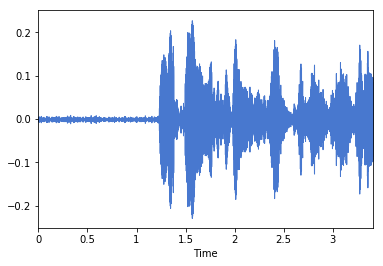

In [243]:
librosa.display.waveplot(y,sr=sr)

In [258]:
Y = librosa.stft(y)

In [259]:
Ymag = librosa.power_to_db(Y)


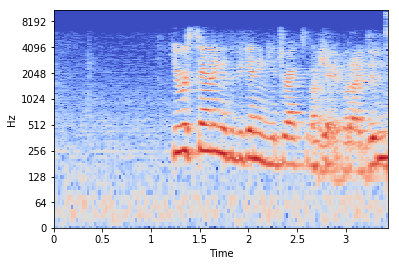

In [266]:
temp = np.abs(librosa.stft(y))
# Play with the parameters, including x_axis and y_axis# Play with the paramete 
librosa.display.specshow(librosa.power_to_db(temp ** 2, ref=np.median), sr=sr, x_axis='time', y_axis='log')

In [90]:
with open(root_path + session_folders[4]+ forced_alignment + sentences_folders[0] +'/'+audio_files[0].split('.')[0] + '.wdseg','r') as openFile:
    for line in openFile.readlines():
        line = line.strip().split()
        print(line)


['SFrm', 'EFrm', 'SegAScr', 'Word']
['0', '45', '406307', '<s>']
['46', '55', '-255457', 'YOU']
['56', '87', '-264117', 'SHOULD(2)']
['88', '101', '-226661', 'YOU']
['102', '118', '-278956', 'SHOULD(2)']
['119', '136', '-123472', 'LOOK']
['137', '161', '90889', 'INTO(3)']
['162', '186', '620750', 'THAT(2)']
['187', '224', '2441', '<sil>']
['225', '244', '1020322', '</s>']
['Total', 'score:', '992046']


In [83]:
audio_files[0].split('.')[0] + '.wdseg'

'Ses01M_impro07_F008.wav'

In [163]:
root_path + session_folders[4]+ forced_alignment + sentences_folders[0] +audio_files[0].split('.')[0] + '.wdseg'

NameError: name 'sentences_folders' is not defined